In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve)
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')
# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [ ]:
# File path
filepath = '2024_Solar_Battery_Charging_Station_Data_for_Jessore (1).csv'

# Load and preprocess data
print("=" * 80)
print("LOADING AND PREPROCESSING DATA")
print("=" * 80)

# Load data
df = pd.read_csv(filepath)
print(f"\nDataset shape: {df.shape}")
print(f"\nColumn names:\n{df.columns.tolist()}")

# Display first few rows
print(f"\nFirst 5 rows:\n{df.head()}")

LOADING AND PREPROCESSING DATA

Dataset shape: (366, 8)

Column names:
['Timestamp', 'Solar Power Input (kW)', 'Battery SoC (%)', 'Temperature (°C)', 'Voltage (V)', 'Current (A)', 'Cycle Count', 'Anomaly Flag']

First 5 rows:
  Timestamp  Solar Power Input (kW)  Battery SoC (%)  Temperature (°C)  \
0  1/1/2024                0.181813        54.071950         22.995657   
1  1/2/2024                0.000000        51.879457         21.112633   
2  1/3/2024                3.533787        50.948622         25.692637   
3  1/4/2024                2.876298        46.626091         28.970678   
4  1/5/2024                0.201783        50.158580         28.430656   

   Voltage (V)  Current (A)  Cycle Count Anomaly Flag  
0     3.636323     1.703473            1            0  
1     3.669188     1.575580            2            0  
2     3.700000     2.394561            3            0  
3     3.700000     1.915215            4            0  
4     3.700000     2.076162            5         

In [ ]:
# Convert Anomaly Flag to binary (0: Normal, 1: Anomaly)
df['Anomaly_Binary'] = df['Anomaly Flag'].apply(
    lambda x: 0 if x == 0 or x == '0' else 1
)

# Check class distribution
print(f"\nAnomaly Distribution:")
print(df['Anomaly_Binary'].value_counts())
print(f"\nAnomaly Percentage: {(df['Anomaly_Binary'].sum() / len(df)) * 100:.2f}%")



Anomaly Distribution:
Anomaly_Binary
0    303
1     63
Name: count, dtype: int64

Anomaly Percentage: 17.21%


In [ ]:
# Select features
feature_columns = ['Battery SoC (%)', 'Temperature (°C)',
                  'Voltage (V)', 'Current (A)', 'Cycle Count']

# Handle any missing values
df[feature_columns] = df[feature_columns].fillna(df[feature_columns].median())

X = df[feature_columns].copy()
X['Power'] = X['Voltage (V)'] * X['Current (A)']
feature_columns.append('Power')

y = df['Anomaly_Binary'].copy()

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature statistics:\n{X.describe()}")




Features shape: (366, 6)
Target shape: (366,)

Feature statistics:
       Battery SoC (%)  Temperature (°C)  Voltage (V)  Current (A)  \
count       366.000000        366.000000   366.000000   366.000000   
mean         49.993403         24.886252     3.136423     2.002193   
std           7.448755          4.508114     0.217708     0.469720   
min          35.402095         15.093584     3.000000     1.057020   
25%          43.701868         21.838856     3.000000     1.599109   
50%          50.012381         25.083038     3.000000     2.029943   
75%          56.417553         28.158215     3.224703     2.346105   
max          64.694499         34.618511     3.700000     2.980127   

       Cycle Count       Power  
count   366.000000  366.000000  
mean    183.500000    6.319663  
std     105.799338    1.693608  
min       1.000000    3.171061  
25%      92.250000    4.863654  
50%     183.500000    6.307996  
75%     274.750000    7.544214  
max     366.000000    9.767000  



EXPLORATORY DATA ANALYSIS


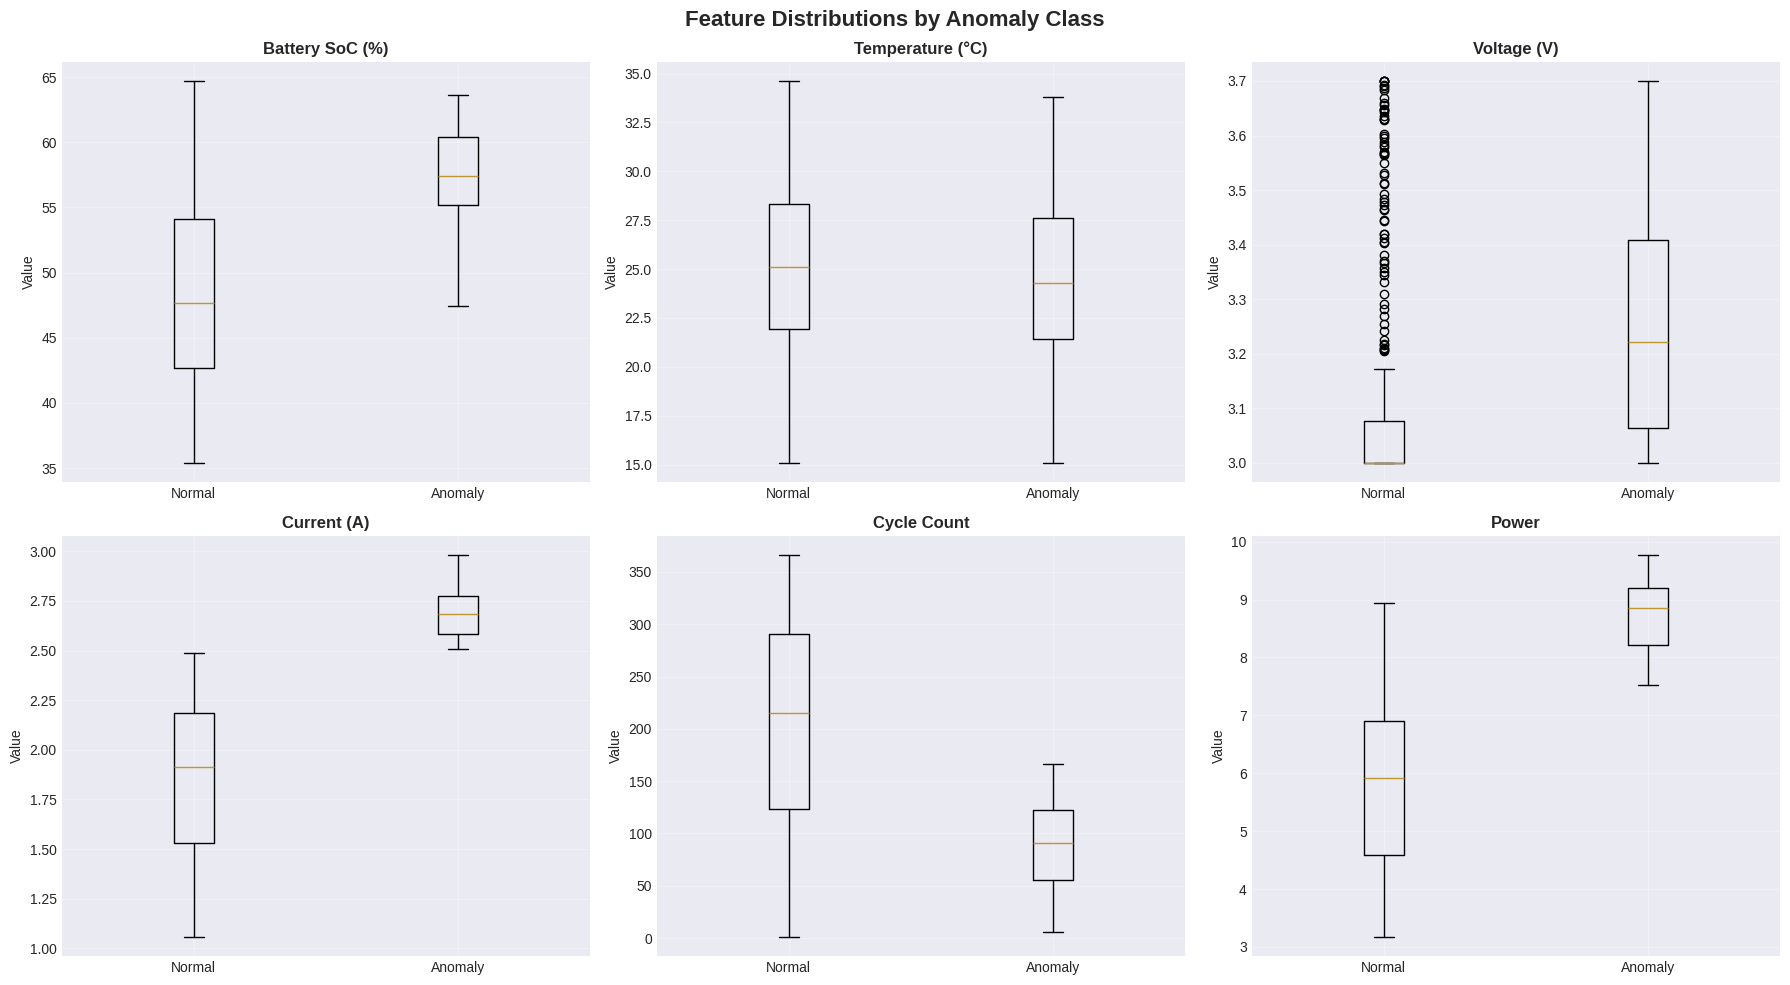

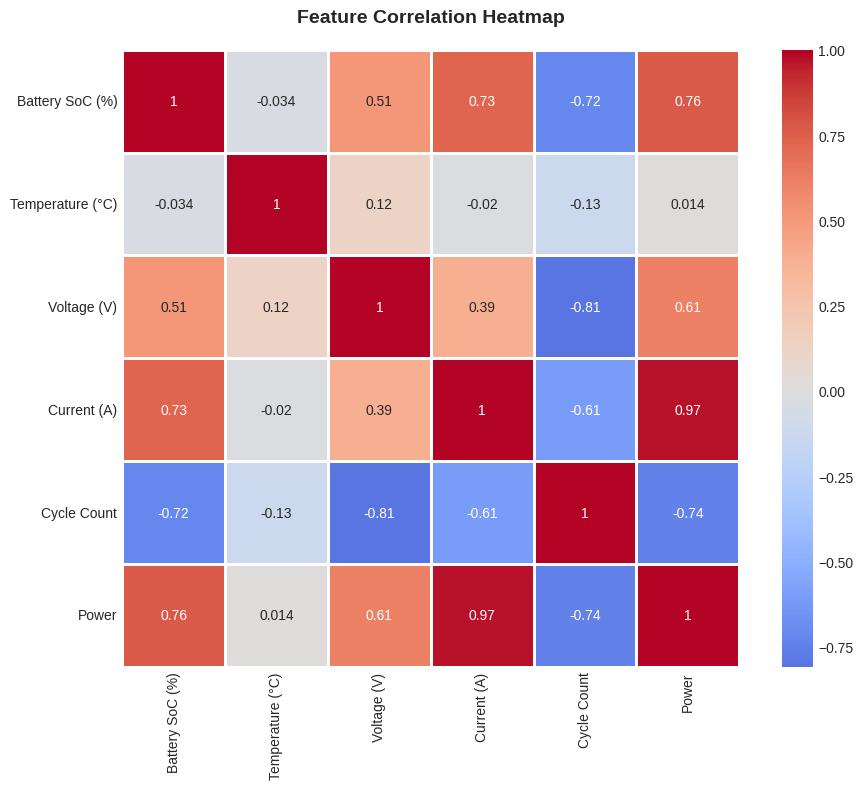

In [ ]:
# Exploratory Data Analysis
print("\n" + "=" * 80)
print("EXPLORATORY DATA ANALYSIS")
print("=" * 80)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Feature Distributions by Anomaly Class', fontsize=16, fontweight='bold')

for idx, feature in enumerate(feature_columns):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]

    # Box plot
    data_normal = X[y == 0][feature]
    data_anomaly = X[y == 1][feature]

    ax.boxplot([data_normal, data_anomaly], labels=['Normal', 'Anomaly'])
    ax.set_title(feature, fontweight='bold')
    ax.set_ylabel('Value')
    ax.grid(True, alpha=0.3)

# Remove extra subplot
if len(feature_columns) < 6:
    fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.savefig('eda_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm',
            center=0, square=True, linewidths=1)
plt.title('Feature Correlation Heatmap', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Prepare data
print("\n" + "=" * 80)
print("DATA PREPARATION")
print("=" * 80)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"\nTraining set anomaly percentage: {(y_train.sum() / len(y_train)) * 100:.2f}%")
print(f"Test set anomaly percentage: {(y_test.sum() / len(y_test)) * 100:.2f}%")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nFeatures scaled using StandardScaler")


DATA PREPARATION

Training set size: 256
Test set size: 110

Training set anomaly percentage: 17.19%
Test set anomaly percentage: 17.27%

Features scaled using StandardScaler


In [ ]:
# Train KNN model
print("\n" + "=" * 80)
print("K-NEAREST NEIGHBORS (KNN) MODEL")
print("=" * 80)

# Hyperparameter tuning
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

print("\nPerforming Grid Search for optimal hyperparameters...")
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation F1 score: {grid_search.best_score_:.4f}")

# Train best model
best_knn = grid_search.best_estimator_
y_pred_knn = best_knn.predict(X_test_scaled)
y_pred_proba_knn = best_knn.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("\n" + "-" * 80)
print("KNN MODEL EVALUATION")
print("-" * 80)
print(f"\nAccuracy: {accuracy_score(y_test, y_pred_knn):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_knn):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_knn):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_knn):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_knn):.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_knn, target_names=['Normal', 'Anomaly']))


K-NEAREST NEIGHBORS (KNN) MODEL

Performing Grid Search for optimal hyperparameters...

Best parameters: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}
Best cross-validation F1 score: 0.9234

--------------------------------------------------------------------------------
KNN MODEL EVALUATION
--------------------------------------------------------------------------------

Accuracy: 0.9727
Precision: 1.0000
Recall: 0.8421
F1 Score: 0.9143
ROC AUC: 0.9986

Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      1.00      0.98        91
     Anomaly       1.00      0.84      0.91        19

    accuracy                           0.97       110
   macro avg       0.98      0.92      0.95       110
weighted avg       0.97      0.97      0.97       110



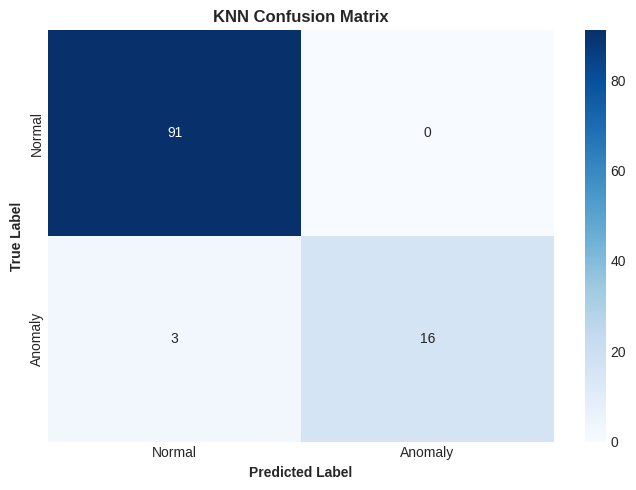

In [ ]:

# Confusion Matrix
plt.figure(figsize=(7, 5))
cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'])
plt.title('KNN Confusion Matrix', fontweight='bold')
plt.ylabel('True Label', fontweight='bold')
plt.xlabel('Predicted Label', fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()




FEATURE IMPORTANCE ANALYSIS

KNN Feature Importance:
----------------------------------------
Current (A): 0.1318 (+/- 0.0224)
Power: 0.0991 (+/- 0.0175)
Battery SoC (%): 0.0155 (+/- 0.0082)
Cycle Count: 0.0136 (+/- 0.0073)
Temperature (°C): 0.0064 (+/- 0.0115)
Voltage (V): -0.0073 (+/- 0.0098)


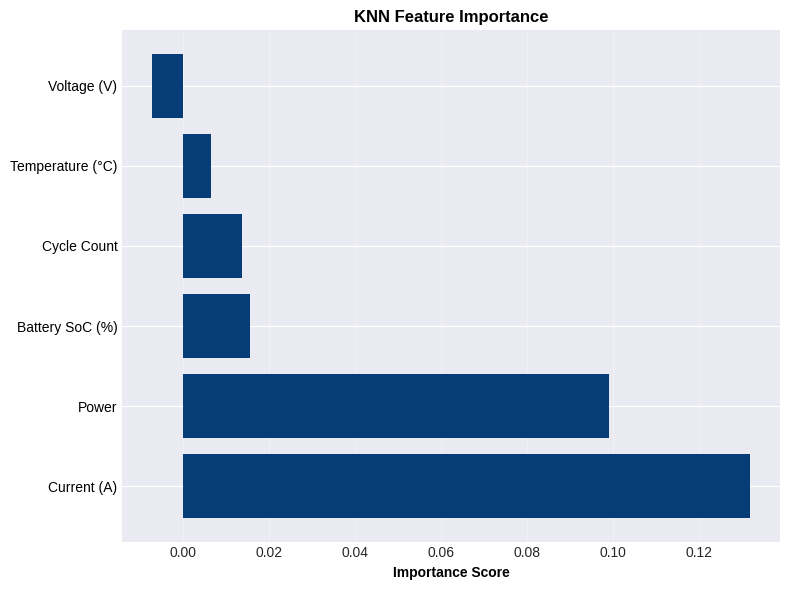


ANALYSIS COMPLETE!

Generated files:
 - eda_boxplots.png
 - correlation_heatmap.png
 - feature_importance.png
 - confusion_matrix.png


In [ ]:
# Feature importance
print("\n" + "=" * 80)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 80)

print("\nKNN Feature Importance:")
print("-" * 40)

# Permutation importance
perm_importance = permutation_importance(
    best_knn, X_test_scaled, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

# Sort features by importance
sorted_idx = perm_importance.importances_mean.argsort()[::-1]

# Print importance scores
for i in sorted_idx:
    print(f"{feature_columns[i]}: {perm_importance.importances_mean[i]:.4f} "
          f"(+/- {perm_importance.importances_std[i]:.4f})")

# Plot
plt.figure(figsize=(8, 6))
y_pos = np.arange(len(feature_columns))
plt.barh(y_pos, perm_importance.importances_mean[sorted_idx], color='#063d76') # Changed color to #063d76
plt.yticks(y_pos, [feature_columns[i] for i in sorted_idx], color='black')
plt.xlabel('Importance Score', fontweight='bold', color='black')
plt.title('KNN Feature Importance', fontweight='bold', color='black')
plt.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE!")
print("=" * 80)
print("\nGenerated files:")
print(" - eda_boxplots.png")
print(" - correlation_heatmap.png")
print(" - feature_importance.png")
print(" - confusion_matrix.png")